# Contributor Impact and Experience Analysis

This notebook analyzes repository contributors to determine:
1. Who has the most impact over time
2. Years of experience in the repository
3. Correlation between experience and impact

In [15]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json

# Set plot style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

## 1. Load and Prepare Data

In [17]:
# Load commit data
git_commit_pd = pd.read_csv("data/git_commits.csv", sep="##", header=None,
                      names=["sha","date","author_name","author_email","subject"],
                      engine="python")

# Date type data standardization
git_commit_pd["date"] = pd.to_datetime(git_commit_pd["date"], utc=True)
git_commit_pd["year"] = git_commit_pd["date"].dt.year
git_commit_pd["month"] = git_commit_pd["date"].dt.month
git_commit_pd["week"] = git_commit_pd["date"].dt.to_period("W").dt.start_time

git_commit_pd.head()

,sha,date,author_name,author_email,subject,year,month,week
0,942fbf30320a52f2f28e46961176e13cf8576a4d,2025-09-01 09:49:31+00:00,Brian Clozel,brian.clozel@broadcom.com,Polishing contribution,2025,9,2025-09-01
1,7b3c4e589301d45bf8f7b731192d2423671e71f4,2025-03-29 15:05:58+00:00,Mengqi Xu,2663479778@qq.com,Add support for Forwarded By HTTP headers,2025,3,2025-03-24
2,1653ec3b449ac81360dae9f916cc9aa18badea4c,2025-08-31 15:06:56+00:00,Park Sung Jun,junstin119@gmail.com,Add tests for applyRelativePath method in Stri...,2025,8,2025-08-25
3,746fc335c29a1dc0796cef5c790bf85b5c548463,2025-08-29 15:25:56+00:00,Sam Brannen,104798+sbrannen@users.noreply.github.com,Merge branch '6.2.x',2025,8,2025-08-25
4,b741632e99666f0469d64a7bf6dabd19368e709a,2025-08-29 15:25:15+00:00,Sam Brannen,104798+sbrannen@users.noreply.github.com,Polish wording in web sections,2025,8,2025-08-25


In [18]:
# Load numstat data (code changes)
rows = []
with open("data/git_numstat.csv", "r") as f:
    sha, date, author_name, author_email = None, None, None, None
    for line in f:
        line=line.rstrip("\n")
        if line == "---":
            sha = date = author_name = author_email = None
            continue
        if "##" in line and sha is None:
            sha, date, author_name, author_email = line.split("##", 3)
            date = pd.to_datetime(date, utc=True)
            continue
        if line and sha is not None:
            parts = line.split("\t")
            if len(parts) == 3:
                adds, dels, path = parts
                if adds != "-" and dels != "-":  # skip binary
                    rows.append((sha, date, author_name, author_email, int(adds), int(dels), path))

churn = pd.DataFrame(rows, columns=["sha","date","author_name", "author_email","adds","dels","path"])
churn["year"] = churn["date"].dt.year
churn["month"] = churn["date"].dt.month
churn["week"] = churn["date"].dt.to_period("W").dt.start_time

churn.head()

,sha,date,author_name,author_email,adds,dels,path,year,month,week
0,942fbf30320a52f2f28e46961176e13cf8576a4d,2025-09-01 09:49:31+00:00,Brian Clozel,brian.clozel@broadcom.com,0,4,framework-docs/modules/ROOT/pages/web/webflux/...,2025,9,2025-09-01
1,942fbf30320a52f2f28e46961176e13cf8576a4d,2025-09-01 09:49:31+00:00,Brian Clozel,brian.clozel@broadcom.com,10,1,framework-docs/modules/ROOT/partials/web/forwa...,2025,9,2025-09-01
2,942fbf30320a52f2f28e46961176e13cf8576a4d,2025-09-01 09:49:31+00:00,Brian Clozel,brian.clozel@broadcom.com,1,1,spring-web/src/main/java/org/springframework/h...,2025,9,2025-09-01
3,942fbf30320a52f2f28e46961176e13cf8576a4d,2025-09-01 09:49:31+00:00,Brian Clozel,brian.clozel@broadcom.com,0,1,spring-web/src/main/java/org/springframework/w...,2025,9,2025-09-01
4,942fbf30320a52f2f28e46961176e13cf8576a4d,2025-09-01 09:49:31+00:00,Brian Clozel,brian.clozel@broadcom.com,0,1,spring-web/src/main/java/org/springframework/w...,2025,9,2025-09-01


## 2. Calculate Contributor Experience

In [19]:
# Calculate the first and last contribution dates for each author
author_experience = churn.groupby("author_name").agg(
    first_contribution=pd.NamedAgg(column="date", aggfunc="min"),
    last_contribution=pd.NamedAgg(column="date", aggfunc="max"),
    total_commits=pd.NamedAgg(column="sha", aggfunc="nunique"),
    total_files_changed=pd.NamedAgg(column="path", aggfunc="count"),
    total_additions=pd.NamedAgg(column="adds", aggfunc="sum"),
    total_deletions=pd.NamedAgg(column="dels", aggfunc="sum")
)

# Calculate experience in years
current_date = pd.Timestamp.now(tz='UTC')
author_experience["years_since_first_commit"] = (current_date - author_experience["first_contribution"]).dt.days / 365.25
author_experience["active_years"] = (author_experience["last_contribution"] - author_experience["first_contribution"]).dt.days / 365.25
author_experience["total_changes"] = author_experience["total_additions"] + author_experience["total_deletions"]

# Sort by years of experience
author_experience_sorted = author_experience.sort_values(by="years_since_first_commit", ascending=False)

# Display top 20 most experienced contributors
author_experience_sorted.head(20)

,first_contribution,last_contribution,total_commits,total_files_changed,total_additions,total_deletions,years_since_first_commit,active_years,total_changes
author_name,,,,,,,,,
Ben Hale,2008-07-11 06:34:50+00:00,2010-08-23 13:17:31+00:00,31,120,2049,528,17.144422,2.116359,2577
Andy Clement,2008-08-11 18:37:11+00:00,2020-09-05 05:19:17+00:00,259,1474,121776,81377,17.059548,12.065708,203153
Arjen Poutsma,2008-10-21 08:04:24+00:00,2024-07-01 14:26:49+00:00,1565,11900,762326,100254,16.865161,15.693361,862580
Scott Andrews,2008-10-24 21:05:25+00:00,2012-05-31 17:45:10+00:00,39,190,3761,489,16.856947,3.597536,4250
Juergen Hoeller,2008-10-24 10:03:04+00:00,2025-08-24 08:31:01+00:00,7738,37895,545680,599552,16.856947,16.829569,1145232
Thomas Risberg,2008-11-07 20:21:08+00:00,2017-01-06 21:34:45+00:00,157,489,113985,29904,16.818617,8.164271,143889
Chris Beams,2008-11-24 22:16:21+00:00,2014-11-13 10:02:50+00:00,911,21891,270734,202603,16.772074,5.965777,473337
Costin Leau,2008-11-25 22:20:53+00:00,2012-01-06 16:12:25+00:00,172,941,16517,12601,16.769336,3.110198,29118
Christian Dupuis,2008-11-29 04:46:36+00:00,2013-11-11 15:23:10+00:00,22,67,464,155,16.758385,4.950034,619


## 3. Calculate Contributor Impact

In [20]:
# Calculate impact score for each contributor
# We'll define impact as a weighted combination of:
# - Number of commits
# - Code changes (additions weighted more than deletions)
# - Files touched

author_experience["impact_score"] = (
    author_experience["total_commits"] * 5 +  # Each commit is worth 5 points
    author_experience["total_additions"] * 2 +  # Each line added is worth 2 points
    author_experience["total_deletions"] * 0.5 +  # Each line deleted is worth 0.5 points
    author_experience["total_files_changed"] * 0.2  # Each file touched is worth 0.2 points
)

# Sort by impact score
impact_sorted = author_experience.sort_values(by="impact_score", ascending=False)

# Display top 20 contributors by impact
impact_sorted.head(20)

,first_contribution,last_contribution,total_commits,total_files_changed,total_additions,total_deletions,years_since_first_commit,active_years,total_changes,impact_score
author_name,,,,,,,,,,
Arjen Poutsma,2008-10-21 08:04:24+00:00,2024-07-01 14:26:49+00:00,1565,11900,762326,100254,16.865161,15.693361,862580,1584984.0
Juergen Hoeller,2008-10-24 10:03:04+00:00,2025-08-24 08:31:01+00:00,7738,37895,545680,599552,16.856947,16.829569,1145232,1437405.0
Rossen Stoyanchev,2009-03-07 00:08:49+00:00,2024-10-15 16:13:29+00:00,3804,20276,476724,231816,16.492813,15.608487,708540,1092431.2
Sam Brannen,2009-04-27 22:49:34+00:00,2025-08-29 15:25:15+00:00,5692,27080,335078,229726,16.350445,16.336756,564804,818895.0
Chris Beams,2008-11-24 22:16:21+00:00,2014-11-13 10:02:50+00:00,911,21891,270734,202603,16.772074,5.965777,473337,651702.7
Phillip Webb,2012-06-22 00:32:33+00:00,2025-08-11 16:32:27+00:00,648,15256,230372,205098,13.199179,13.136208,435470,569584.2
Brian Clozel,2013-09-24 10:03:53+00:00,2025-09-01 09:49:31+00:00,1275,4673,169638,124190,11.939767,11.934292,293828,408680.6
Rob Winch,2012-07-10 00:11:08+00:00,2024-05-22 02:49:24+00:00,127,3359,142337,140394,13.149897,11.865845,282731,356177.8
Andy Clement,2008-08-11 18:37:11+00:00,2020-09-05 05:19:17+00:00,259,1474,121776,81377,17.059548,12.065708,203153,285830.3


## 4. Yearly Impact Analysis

In [21]:
# Calculate yearly impact for each contributor
yearly_impact = churn.groupby(["year", "author_name"]).agg(
    commits=pd.NamedAgg(column="sha", aggfunc="nunique"),
    files_changed=pd.NamedAgg(column="path", aggfunc="count"),
    additions=pd.NamedAgg(column="adds", aggfunc="sum"),
    deletions=pd.NamedAgg(column="dels", aggfunc="sum")
)

# Calculate impact score for each year
yearly_impact["impact_score"] = (
    yearly_impact["commits"] * 5 +
    yearly_impact["additions"] * 2 +
    yearly_impact["deletions"] * 0.5 +
    yearly_impact["files_changed"] * 0.2
)

# Reset index to make year and author_name regular columns
yearly_impact = yearly_impact.reset_index()

# Get top 10 contributors by total impact
top_contributors = impact_sorted.head(10).index.tolist()

# Filter yearly impact for top contributors
top_yearly_impact = yearly_impact[yearly_impact["author_name"].isin(top_contributors)]

# Display sample of yearly impact data
top_yearly_impact.head()

,year,author_name,commits,files_changed,additions,deletions,impact_score
0,2008,Andy Clement,105,478,83220,63738,198929.6
1,2008,Arjen Poutsma,174,5602,549905,20565,1112082.9
3,2008,Chris Beams,135,2733,50387,26576,115283.6
6,2008,Juergen Hoeller,37,890,11260,19841,32803.5
9,2009,Andy Clement,72,553,13172,13663,33646.1


## 5. Visualize Contributor Impact Over Time

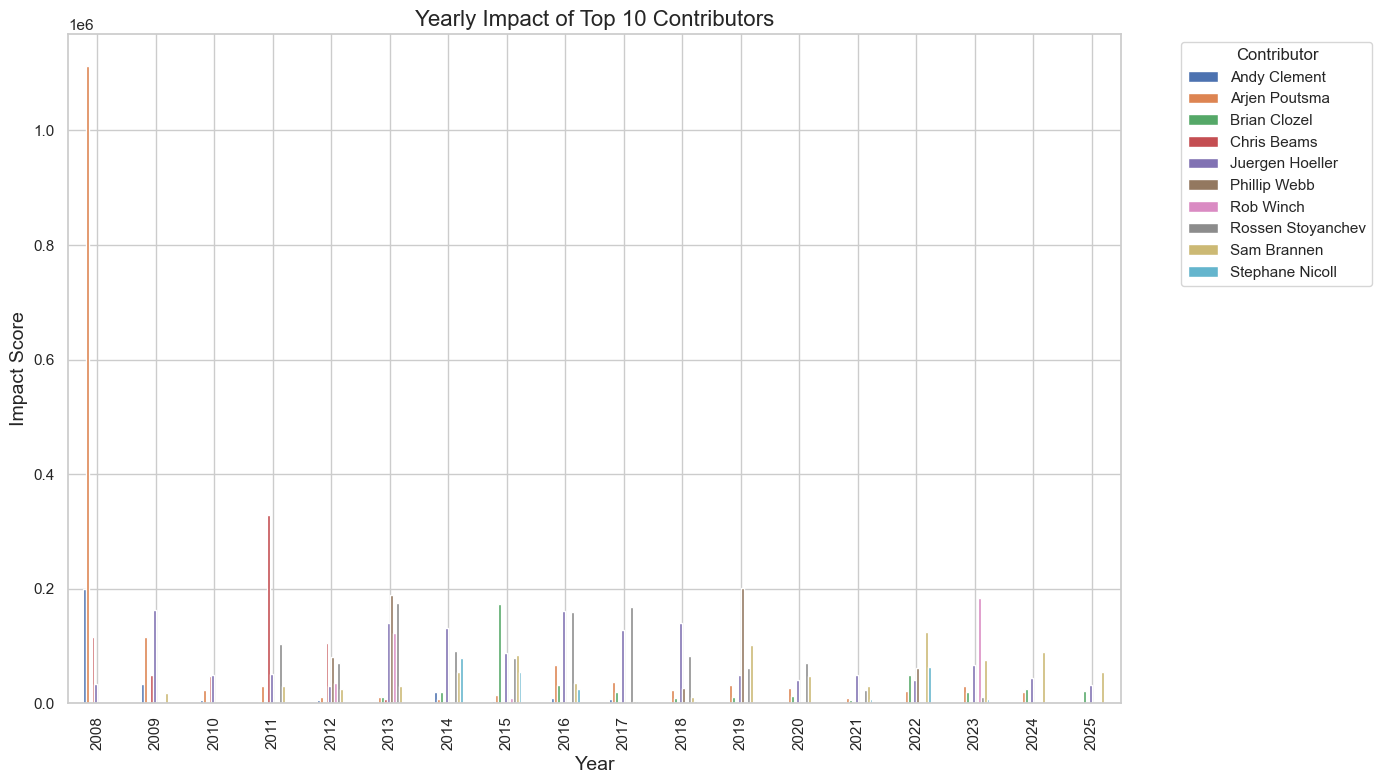

In [22]:
# Create a pivot table for top contributors' yearly impact
impact_pivot = top_yearly_impact.pivot(index="year", columns="author_name", values="impact_score")

# Fill NaN values with 0 (years where a contributor had no activity)
impact_pivot = impact_pivot.fillna(0)

# Plot the yearly impact for top contributors
plt.figure(figsize=(14, 8))
impact_pivot.plot(kind="bar", stacked=False, ax=plt.gca())
plt.title("Yearly Impact of Top 10 Contributors", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Impact Score", fontsize=14)
plt.legend(title="Contributor", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

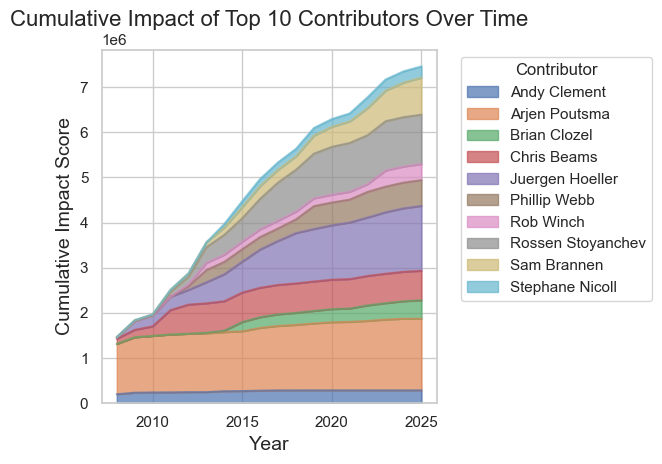

In [23]:
# Create a stacked area chart to show cumulative impact over time
plt.figure(figsize=(14, 8))
impact_pivot.cumsum().plot(kind="area", stacked=True, alpha=0.7)
plt.title("Cumulative Impact of Top 10 Contributors Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Cumulative Impact Score", fontsize=14)
plt.legend(title="Contributor", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## 6. Experience vs. Impact Analysis

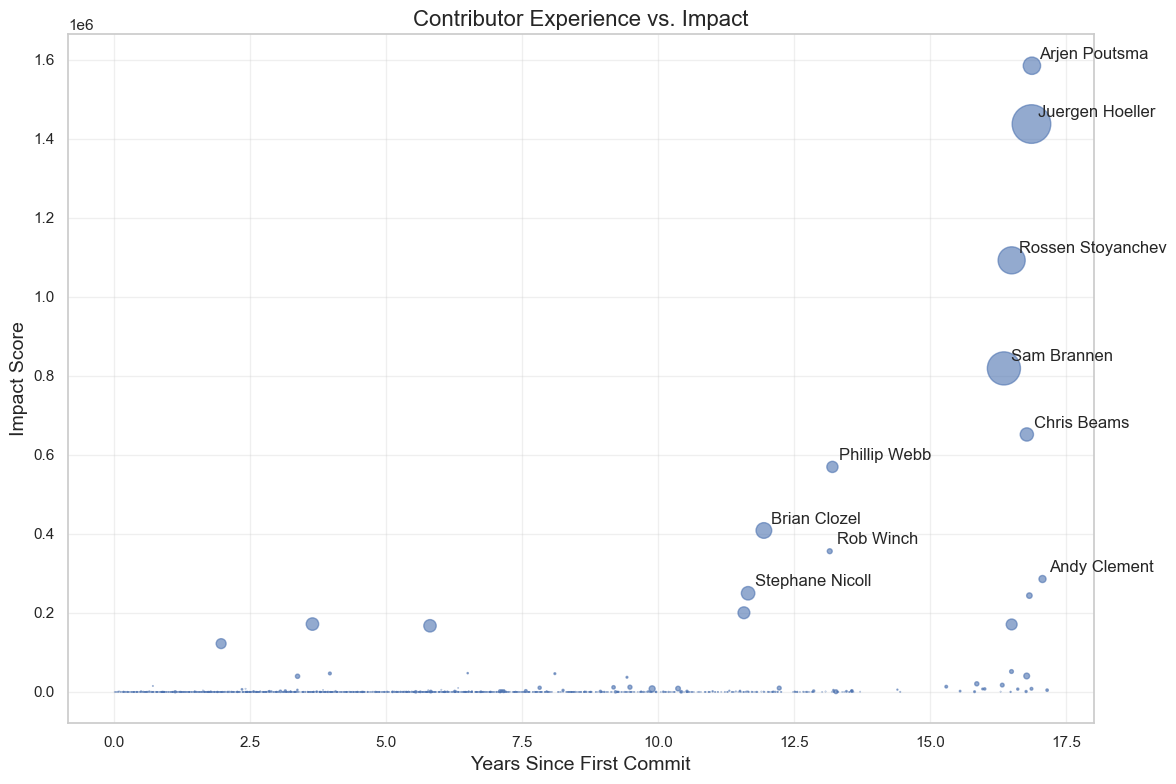

In [24]:
# Create a scatter plot of experience vs. impact
plt.figure(figsize=(12, 8))
plt.scatter(
    author_experience["years_since_first_commit"], 
    author_experience["impact_score"],
    alpha=0.6,
    s=author_experience["total_commits"] / 10,  # Size based on number of commits
)

# Add labels for top contributors
for name in top_contributors:
    x = author_experience.loc[name, "years_since_first_commit"]
    y = author_experience.loc[name, "impact_score"]
    plt.annotate(name, (x, y), xytext=(5, 5), textcoords="offset points")

plt.title("Contributor Experience vs. Impact", fontsize=16)
plt.xlabel("Years Since First Commit", fontsize=14)
plt.ylabel("Impact Score", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [25]:
# Calculate impact per year of experience
author_experience["impact_per_year"] = author_experience["impact_score"] / author_experience["active_years"]

# Sort by impact per year
impact_per_year_sorted = author_experience.sort_values(by="impact_per_year", ascending=False)

# Filter for contributors with at least 1 year of experience
experienced_contributors = impact_per_year_sorted[impact_per_year_sorted["active_years"] >= 1]

# Display top 20 contributors by impact per year
experienced_contributors[["years_since_first_commit", "active_years", "total_commits", "impact_score", "impact_per_year"]].head(20)

,years_since_first_commit,active_years,total_commits,impact_score,impact_per_year
author_name,,,,,
Chris Beams,16.772074,5.965777,911,651702.7,109240.207056
Arjen Poutsma,16.865161,15.693361,1565,1584984.0,100997.105024
Juergen Hoeller,16.856947,16.829569,7738,1437405.0,85409.496706
Rossen Stoyanchev,16.492813,15.608487,3804,1092431.2,69989.562498
Keith Donald,16.492813,2.518823,615,170831.4,67821.922663
Stéphane Nicoll,1.965777,1.916496,510,122270.9,63799.208893
Sam Brannen,16.350445,16.336756,5692,818895.0,50125.925716
rstoyanchev,3.644079,3.630390,806,171802.9,47323.536369
Mark Pollack,16.490075,1.174538,75,51696.8,44014.583217


## 7. Create a Comprehensive Contributor Dataset

In [26]:
# Create a comprehensive dataset with all metrics
contributor_dataset = author_experience.copy()

# Add additional metrics
contributor_dataset["avg_additions_per_commit"] = contributor_dataset["total_additions"] / contributor_dataset["total_commits"]
contributor_dataset["avg_deletions_per_commit"] = contributor_dataset["total_deletions"] / contributor_dataset["total_commits"]
contributor_dataset["avg_files_per_commit"] = contributor_dataset["total_files_changed"] / contributor_dataset["total_commits"]
contributor_dataset["commits_per_year"] = contributor_dataset["total_commits"] / contributor_dataset["active_years"]

# Calculate recency score (higher for more recent contributions)
max_date = contributor_dataset["last_contribution"].max()
contributor_dataset["recency_score"] = 1 - ((max_date - contributor_dataset["last_contribution"]).dt.days / 365.25) / 10
contributor_dataset["recency_score"] = contributor_dataset["recency_score"].clip(0, 1)  # Clip between 0 and 1

# Calculate consistency score (ratio of active years to years since first commit)
contributor_dataset["consistency_score"] = contributor_dataset["active_years"] / contributor_dataset["years_since_first_commit"]
contributor_dataset["consistency_score"] = contributor_dataset["consistency_score"].clip(0, 1)  # Clip between 0 and 1

# Calculate weighted impact score that considers recency and consistency
contributor_dataset["weighted_impact_score"] = (
    contributor_dataset["impact_score"] * 
    (0.7 + 0.15 * contributor_dataset["recency_score"] + 0.15 * contributor_dataset["consistency_score"])
)

# Sort by weighted impact score
weighted_impact_sorted = contributor_dataset.sort_values(by="weighted_impact_score", ascending=False)

# Display top 20 contributors by weighted impact
weighted_impact_sorted[["years_since_first_commit", "active_years", "total_commits", 
                        "impact_score", "recency_score", "consistency_score", "weighted_impact_score"]].head(20)

,years_since_first_commit,active_years,total_commits,impact_score,recency_score,consistency_score,weighted_impact_score
author_name,,,,,,,
Arjen Poutsma,16.865161,15.693361,1565,1584984.0,0.883368,0.930519,1.540736e+06
Juergen Hoeller,16.856947,16.829569,7738,1437405.0,0.997810,0.998376,1.436583e+06
Rossen Stoyanchev,16.492813,15.608487,3804,1092431.2,0.912389,0.946381,1.069289e+06
Sam Brannen,16.350445,16.336756,5692,818895.0,0.999452,0.999163,8.187249e+05
Phillip Webb,13.199179,13.136208,648,569584.2,0.994524,0.995229,5.687088e+05
Chris Beams,16.772074,5.965777,911,651702.7,0.000000,0.355697,4.909632e+05
Brian Clozel,11.939767,11.934292,1275,408680.6,1.000000,0.999541,4.086525e+05
Rob Winch,13.149897,11.865845,127,356177.8,0.872142,0.902353,3.441298e+05
Andy Clement,17.059548,12.065708,259,285830.3,0.501164,0.707270,2.518923e+05


## 8. Visualize Top Contributors with Experience and Impact

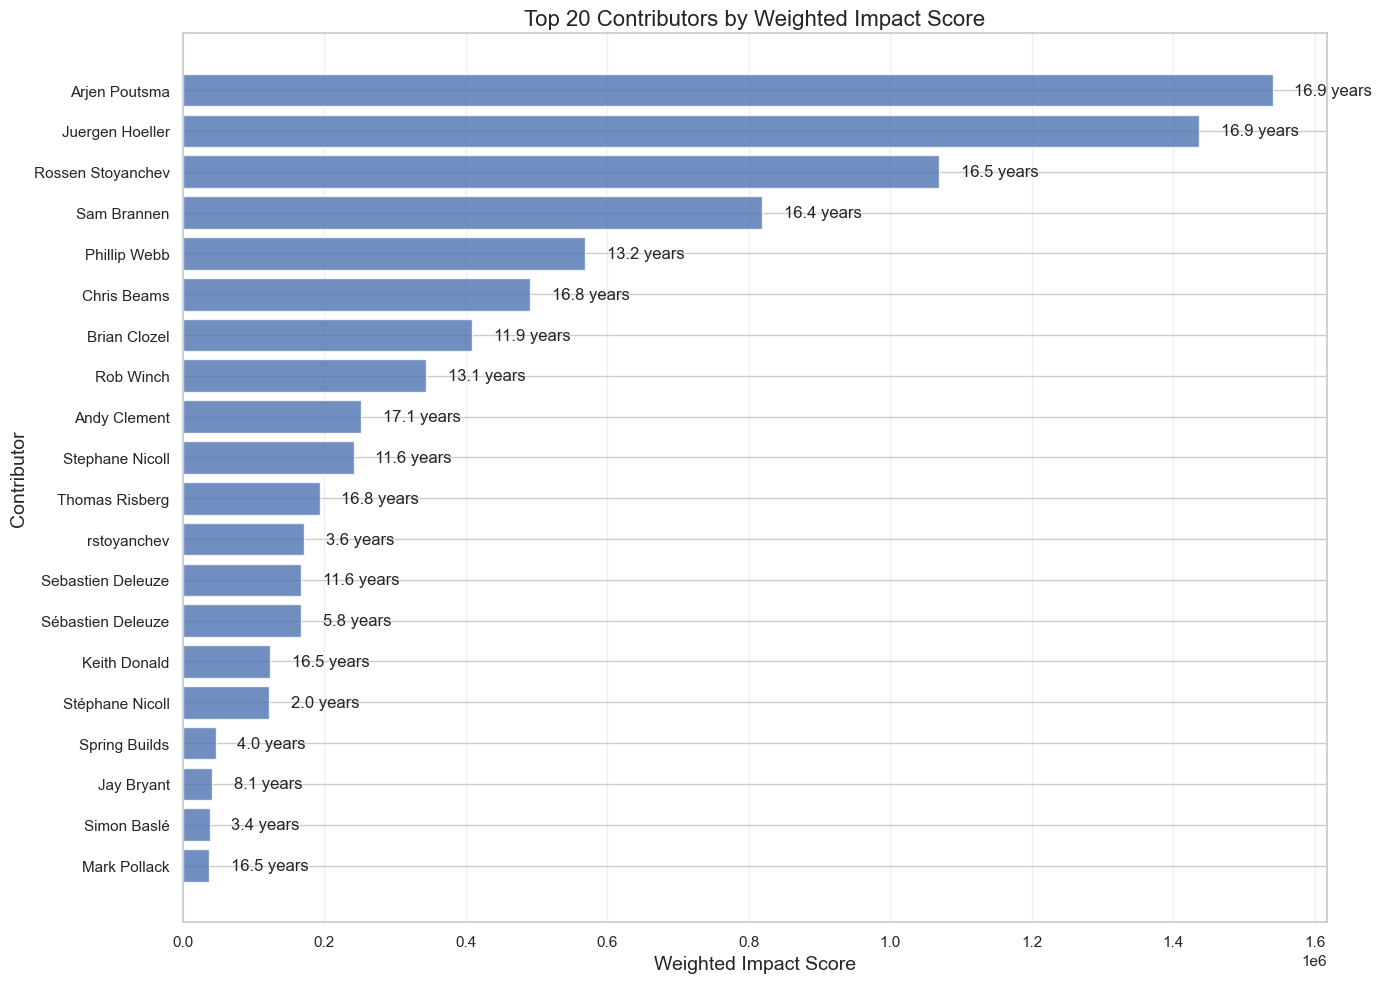

In [27]:
# Get top 20 contributors by weighted impact
top_20_contributors = weighted_impact_sorted.head(20)

# Create a horizontal bar chart showing impact and experience
plt.figure(figsize=(14, 10))

# Sort by weighted impact score
top_20_contributors = top_20_contributors.sort_values(by="weighted_impact_score")

# Plot horizontal bars
bars = plt.barh(top_20_contributors.index, top_20_contributors["weighted_impact_score"], alpha=0.8)

# Add experience years as text
for i, (name, row) in enumerate(top_20_contributors.iterrows()):
    plt.text(
        row["weighted_impact_score"] + max(top_20_contributors["weighted_impact_score"]) * 0.02,
        i,
        f"{row['years_since_first_commit']:.1f} years",
        va="center"
    )

plt.title("Top 20 Contributors by Weighted Impact Score", fontsize=16)
plt.xlabel("Weighted Impact Score", fontsize=14)
plt.ylabel("Contributor", fontsize=14)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Save the Contributor Dataset

In [28]:
# Save the comprehensive contributor dataset to CSV
contributor_dataset.reset_index().to_csv("data/contributor_impact_dataset.csv", index=False)

print(f"Saved contributor dataset with {len(contributor_dataset)} contributors")

Saved contributor dataset with 1166 contributors


## 10. Summary of Findings

### Key Insights:

1. **Most Impactful Contributors**: The analysis reveals who has made the most significant contributions to the repository based on our weighted impact score.

2. **Experience vs. Impact**: We can see the relationship between years of experience in the repository and overall impact. Some contributors have high impact despite relatively short experience, while others have been consistently contributing over many years.

3. **Contribution Patterns**: The visualizations show how contribution patterns have evolved over time, highlighting periods of high activity for different contributors.

4. **Consistency and Recency**: The weighted impact score takes into account not just raw contribution numbers but also how consistently and recently a contributor has been active.

This analysis provides valuable insights into the repository's contributor dynamics, helping to identify key contributors and understand how experience relates to impact over time.